### We've seen random walk which is not very exciting since this is one of the rare situations where forecasting is not really possible in the sense that you're stuck with naive forecasts, there is no model to apply in those situations

## `Moving Average`
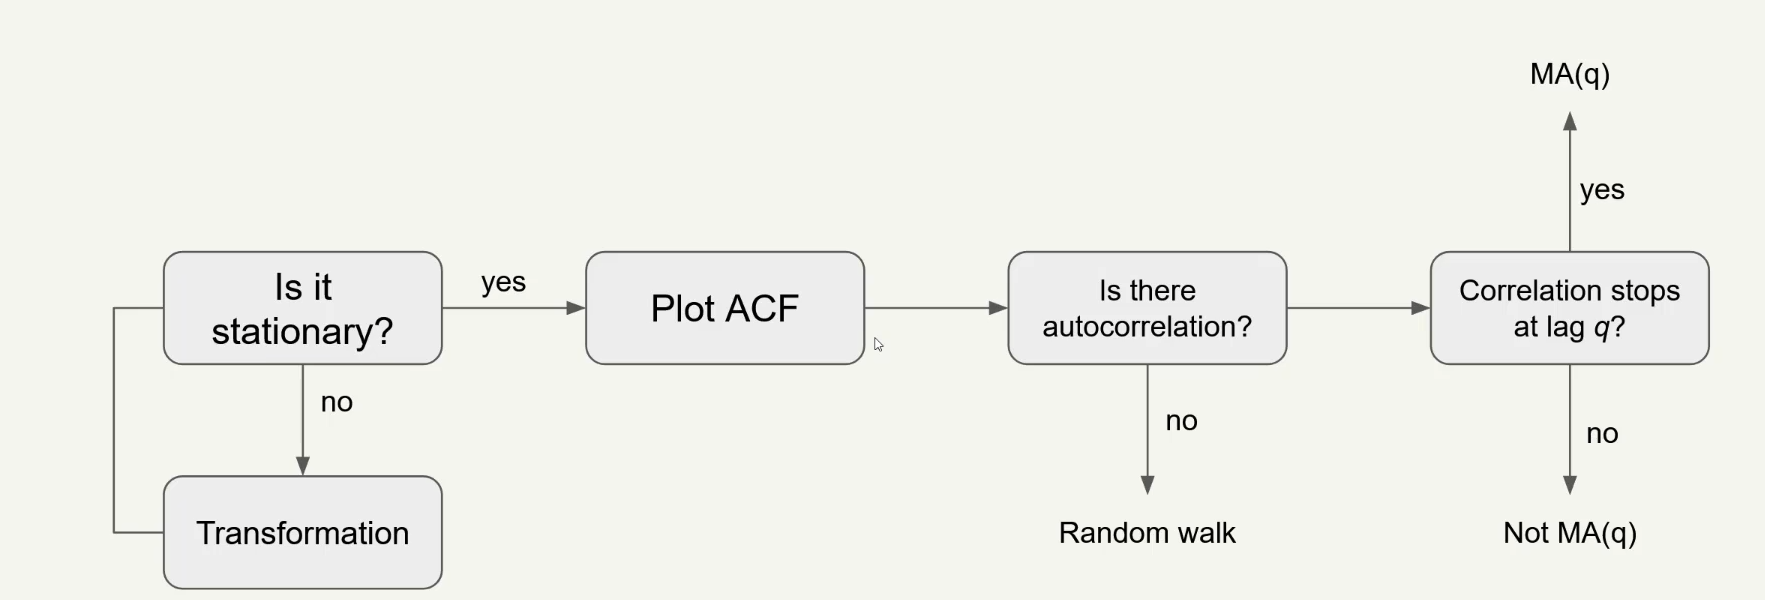

### Moving average model states that the current value depends on the present ERROR and past ERROR terms.
### Order of the model determines how many past errors we consider.

### White noise is independent and normally distributed.
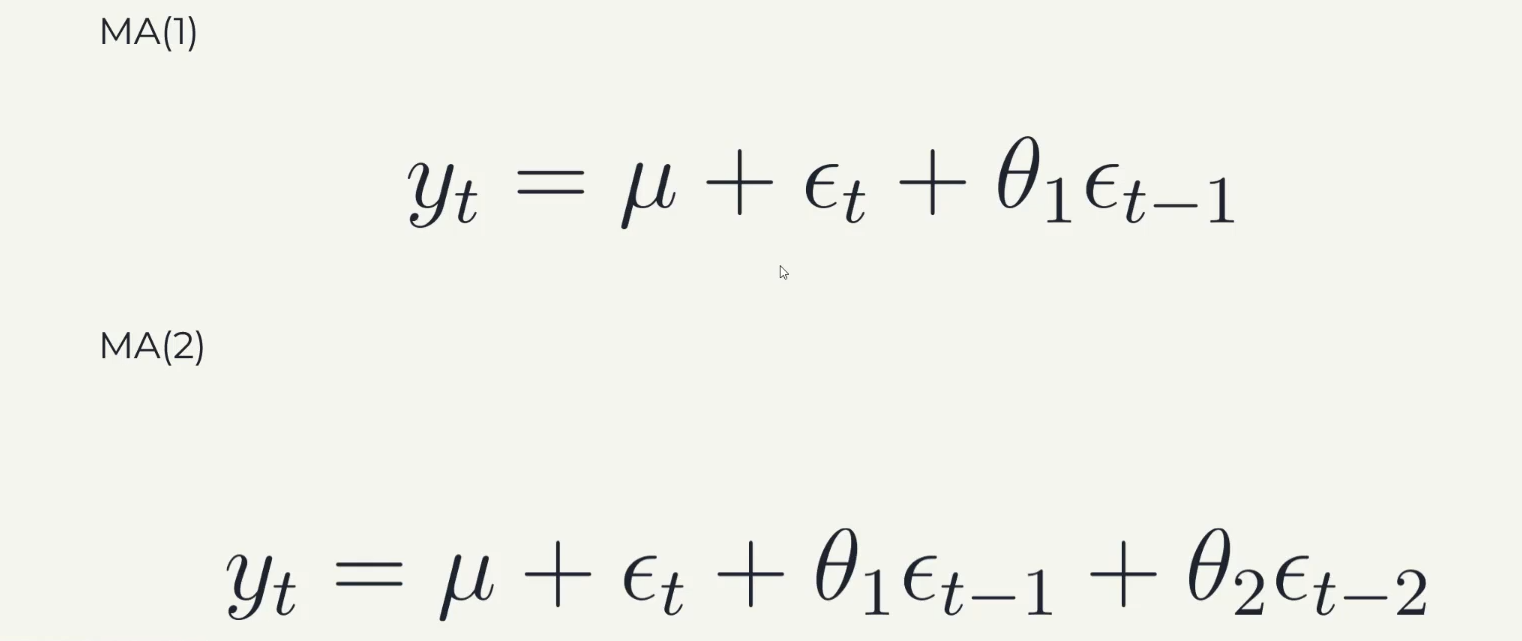



### It is not something you can't predict for longer horizons than Q, it just becomes flat line after Q.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only GPU 0
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = "1"  # Use mixed precision for performance
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess # this is how we simulate a MA process
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX # this is what we use to actually implement MA process
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Simulate MA Process.

In [3]:
ma1 = np.array([1,0.8])
ar1 = np.array([1,0])

ma1_process = ArmaProcess(ar1, ma1).generate_sample(10000)

In [4]:
plt.rcParams["figure.figsize"] = (9,6)

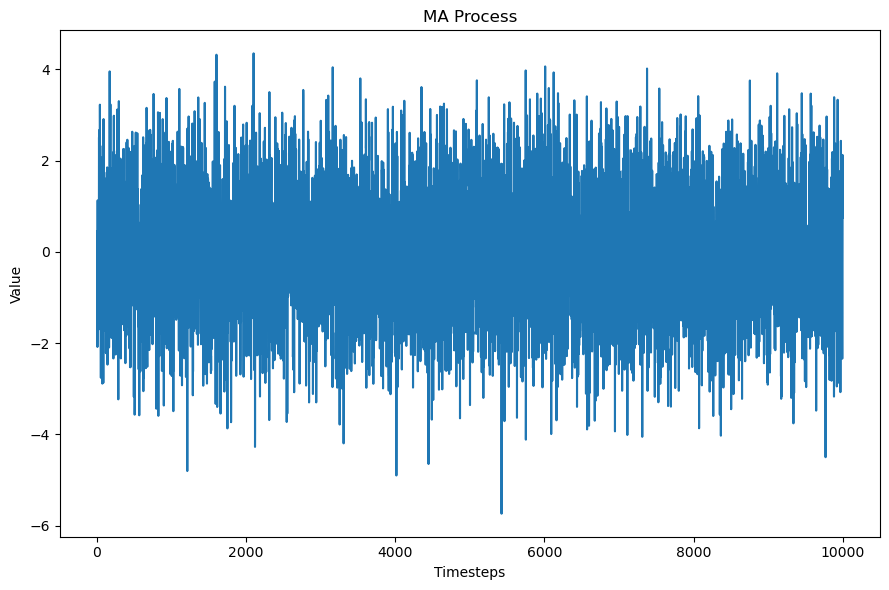

In [5]:
fig , ax = plt.subplots()

ax.plot(ma1_process)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")
ax.set_title("MA Process")
plt.tight_layout()

In [6]:
ADF_result = adfuller(ma1_process)

print(f"ADF - Test statistic : {ADF_result[0]}")
print(f"ADF - P value: {ADF_result[1]}")

ADF - Test statistic : -26.46367288498364
ADF - P value: 0.0


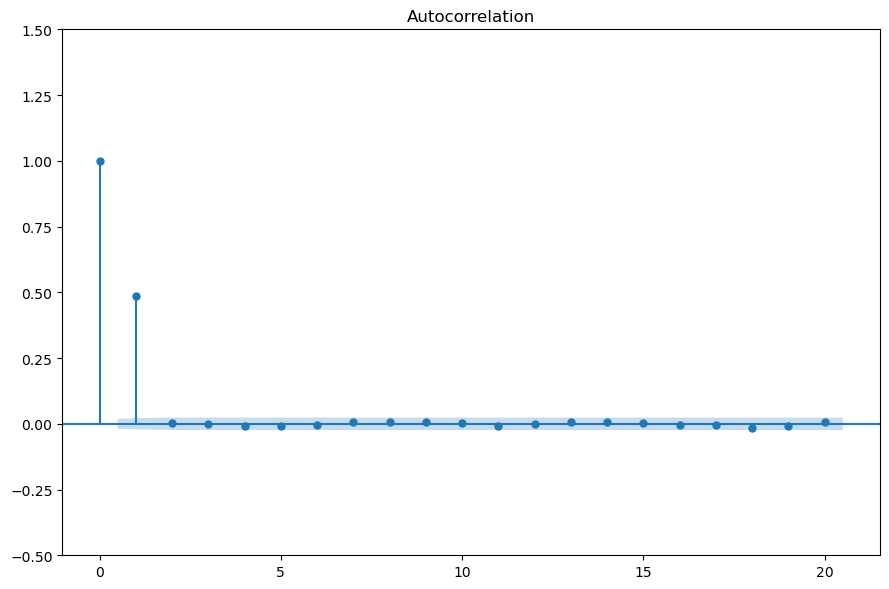

In [7]:
# Since pval < 0.05, the time series is stationary in nature.

plot_acf(ma1_process, lags=20)
plt.ylim(-0.5, 1.5)
plt.tight_layout()

## `ACF Plot is useful to determine the order of the Moving Average Process.`

In [8]:
import pandas as pd
simulated_ma_process = pd.DataFrame({"value" : ma1_process})
simulated_ma_process.head()

,value
0,0.448392
1,-0.834084
2,-1.100856
3,0.260278
4,0.299697


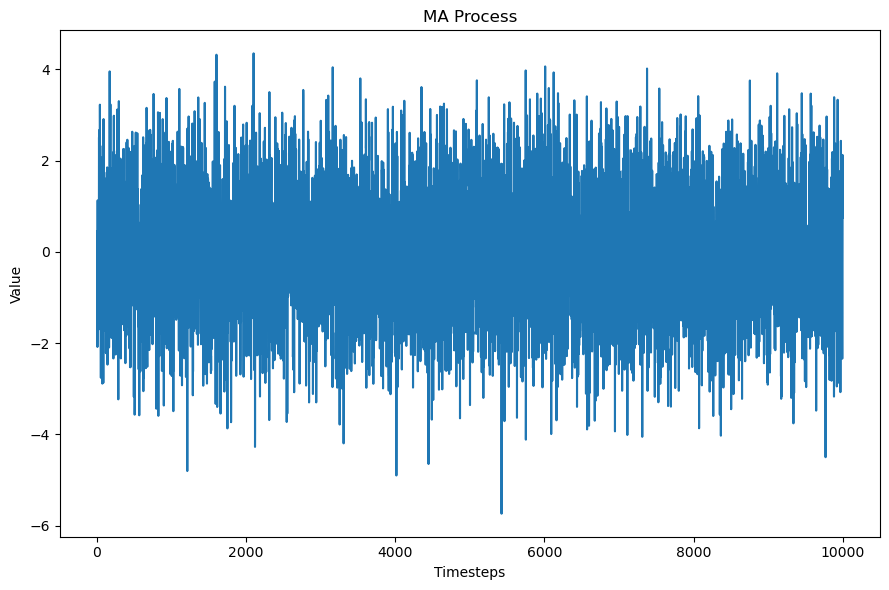

In [9]:
fig, ax = plt.subplots()
ax.plot(simulated_ma_process["value"])
ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")
ax.set_title("MA Process")
plt.tight_layout()

### Train-Test Split

In [10]:
train = simulated_ma_process[:-1000]
test = simulated_ma_process[-1000:]

In [11]:
len(train) , len(test)

(9000, 1000)

In [12]:
simulated_ma_process.iloc[8999]

value    1.16599
Name: 8999, dtype: float64

In [13]:
train.iloc[-1]

value    1.16599
Name: 8999, dtype: float64

### if you forecast beyond the order of the MA Model, then it is just a constant line

### Instead of forecasting 100 timesteps in a single shot, we're going to `forecast certain timesteps until we've predicted entire test set`

In [14]:
def rolling_predictions(df, last_train_val, train_len, horizon, window, method):
    # df : dataframe
    # last_train_val : it is going to be super useful, when you make predictions using MA model, your predictions are transformed. so we need to undo those transformations.
    # train_len :  length of the training set
    # horizon : length of test set
    # window : the number of time steps that we predict at a time.

    TOTAL_LEN = train_len + horizon
    
    if method == "mean":
        pred_mean = []

        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        pred_mean = np.concatenate((last_train_val, pred_mean))
        pred_mean = pred_mean.cumsum()

        return pred_mean[:1000]

    elif method == "last":
        pred_last_value = []

        for i in range(train_len, TOTAL_LEN, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        pred_last_value = np.concatenate((last_train_val, pred_last_value))
        pred_last_value = pred_last_value.cumsum()
        
        return pred_last_value[:1000]

    elif method == "MA":
        pred_MA = []

        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(0,0,1))
            res = model.fit(disp=False)
            predictions  = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        pred_MA = np.concatenate((last_train_val, pred_MA))
        pred_MA = pred_MA.cumsum()

        return pred_MA[:1000]

        


In [15]:
simulated_ma_process.iloc[:9000]

,value
0,0.448392
1,-0.834084
2,-1.100856
3,0.260278
4,0.299697
...,...
8995,-2.453605
8996,-0.176562
8997,0.030413
8998,-0.208623


In [16]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [17]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
# Force tensorflow to use GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is now being used!")
    except RuntimeError as e:
        print(e)

GPU is now being used!


In [19]:
tf.test.is_built_with_cuda()

True

In [20]:
pred_df = simulated_ma_process[-1000:].copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = simulated_ma_process.iloc[8999].values

windows = [1, 2, 5, 10]

for window in windows:
    pred_mean = rolling_predictions(simulated_ma_process, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'mean')
    pred_last = rolling_predictions(simulated_ma_process, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    pred_MA = rolling_predictions(simulated_ma_process, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'MA')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_{window}'] = pred_last
    pred_df[f'pred_MA_{window}'] = pred_MA

pred_df.head()

,value,pred_mean_1,pred_last_1,pred_MA_1,pred_mean_2,pred_last_2,pred_MA_2,pred_mean_5,pred_last_5,pred_MA_5,pred_mean_10,pred_last_10,pred_MA_10
9000,0.757329,1.165990,1.165990,1.165990,1.165990,1.165990,1.165990,1.165990,1.165990,1.165990,1.165990,1.165990,1.165990
9001,0.057505,1.133514,2.331979,1.999922,1.133514,2.331979,1.999922,1.133514,2.331979,1.999922,1.133514,2.331979,1.999922
9002,1.651878,1.101127,3.089308,1.939171,1.101039,3.497969,1.999922,1.101039,3.497969,1.999922,1.101039,3.497969,1.999922
9003,2.275057,1.068749,3.146812,2.032954,1.068662,3.555473,2.093704,1.068564,4.663958,1.999922,1.068564,4.663958,1.999922
9004,-0.266738,1.036559,4.798690,3.268667,1.036284,3.612978,2.093704,1.036089,5.829948,1.999922,1.036089,5.829948,1.999922


In [21]:
import tensorflow as tf
print(tf.config.list_logical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))


[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


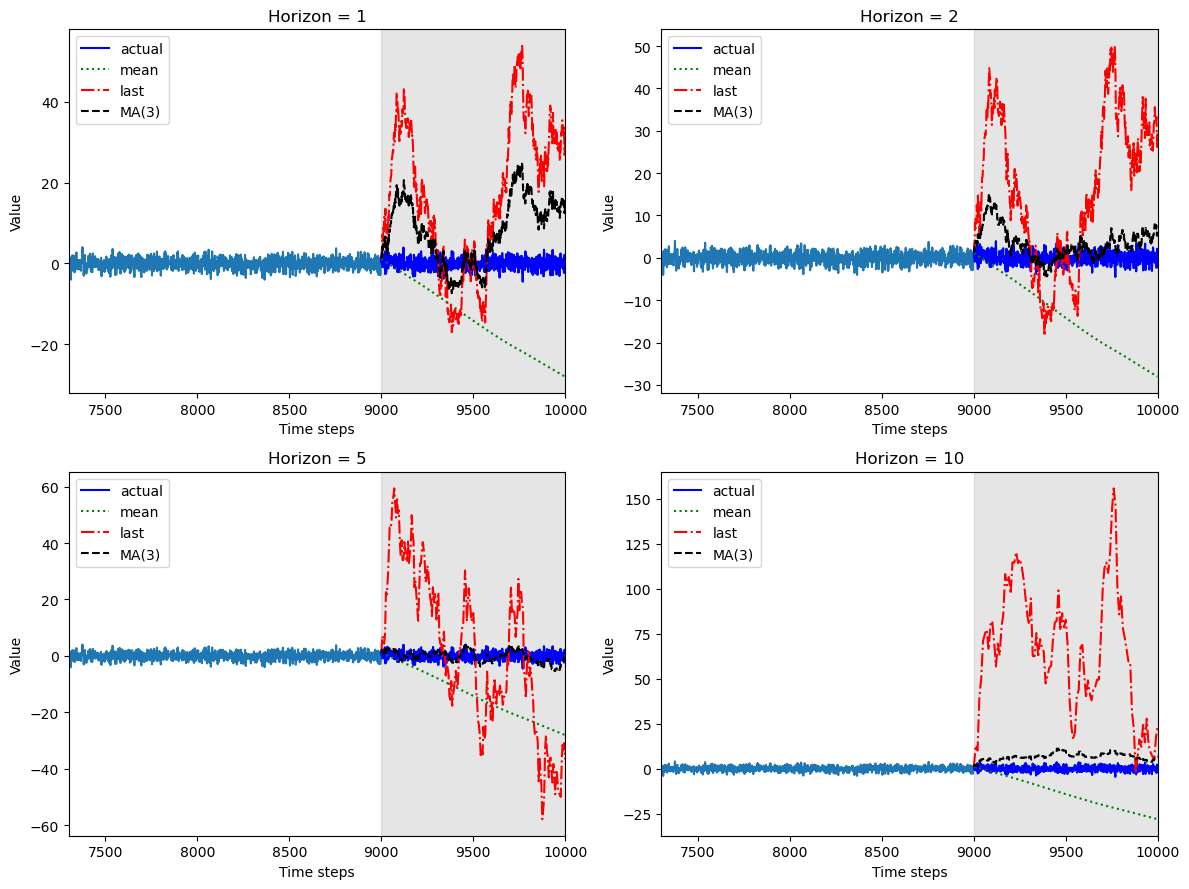

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(simulated_ma_process['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'pred_MA_{windows[i]}'], 'k--', label='MA(3)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.axvspan(9000, 10000, color='#808080', alpha=0.2)
    ax.set_xlim(7300, 10000)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

In [24]:
from sklearn.metrics import mean_absolute_error

mae_mean_1 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_1'])
mae_last_1 = mean_absolute_error(pred_df['value'], pred_df['pred_last_1'])
mae_MA_1 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_1'])

mae_mean_2 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_2'])
mae_last_2 = mean_absolute_error(pred_df['value'], pred_df['pred_last_2'])
mae_MA_2 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_2'])

mae_mean_5 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_5'])
mae_last_5 = mean_absolute_error(pred_df['value'], pred_df['pred_last_5'])
mae_MA_5 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_5'])

mae_mean_10 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_10'])
mae_last_10 = mean_absolute_error(pred_df['value'], pred_df['pred_last_10'])
mae_MA_10 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_10'])

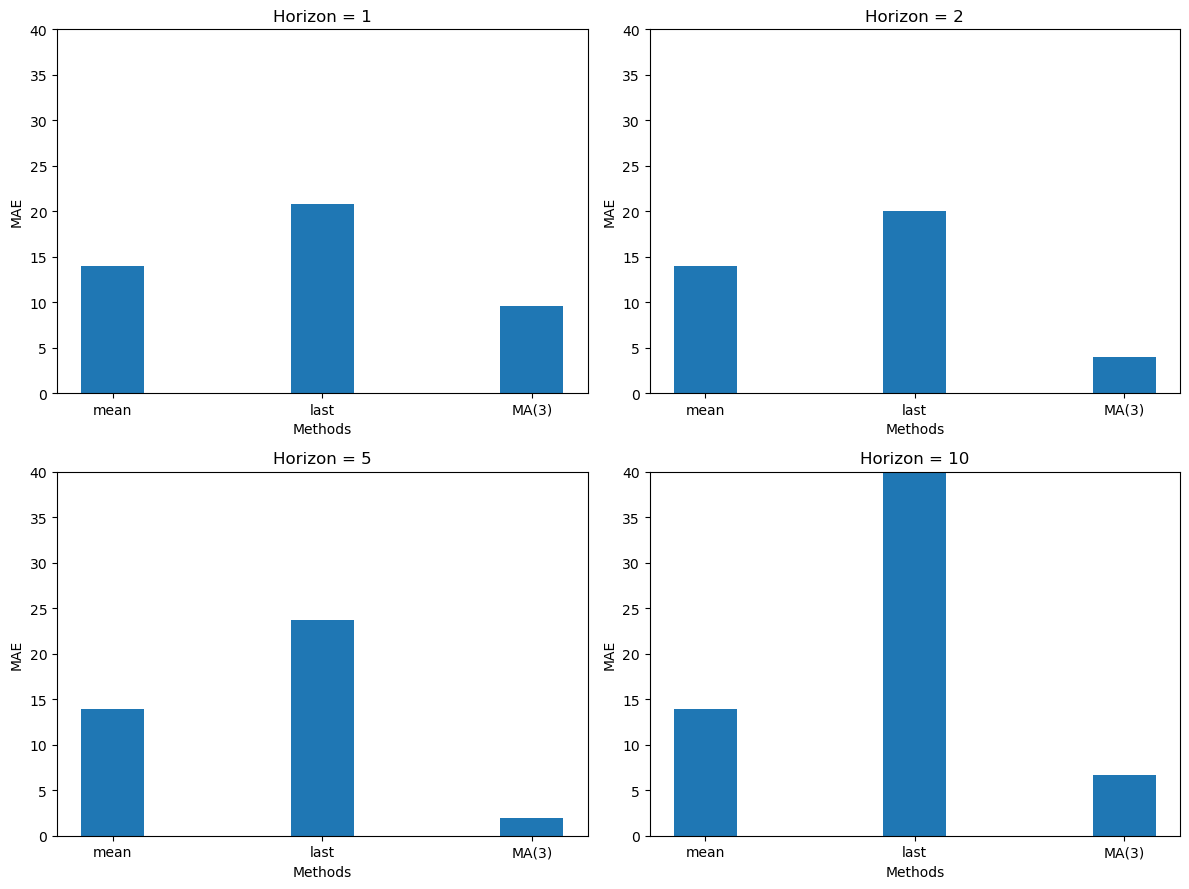

In [31]:
maes_mean = [mae_mean_1, mae_mean_2, mae_mean_5, mae_mean_10]
maes_last = [mae_last_1, mae_last_2, mae_last_5, mae_last_10]
maes_MA = [mae_MA_1, mae_MA_2, mae_MA_5, mae_MA_10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['mean', 'last', 'MA(3)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [maes_mean[i], maes_last[i], maes_MA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 40)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    # for index, value in enumerate(y):
    #     ax.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

plt.tight_layout()